# Welcome to the notebook that trains the model to extract rod positions and angles

Welcome to foosbot

In [1]:
#!pip install keras
#!pip install numpy
#!pip install imageio
#!pip install matplotlib
#!pip install opencv-python

In [2]:
from __future__ import print_function


from video_file import *

import importlib
try:
    importlib.reload(video_file)
except:
    pass

import cv2
import sys
import os
import csv
import numpy as np
from random import randint
from random import shuffle

from PIL import Image
import imageio
import itertools as it

import tensorflow as tf
import keras
print("Keras version %s" % keras.__version__)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

print("Tensorflow version %s" % tf.__version__)

import pprint
pp = pprint.PrettyPrinter(depth=6)



position_rel_indexes = [0]
frame_rel_indexes = [0]

# Create the image transformer
data_path  = ".\\..\\..\\TrainingData\\Processed\\RodTrainingDataAngles\\Result\\settings_just_two.tsv"
print("Opening training frames from config %s." % (data_path))
transformer = VideoTransform( zoom_range=0.1, rotation_range=5, width_shift_range=0.1, height_shift_range=0.1, shear_range= 0.1, fill_mode='nearest', vertical_flip=False, horizontal_flip=True, horizontal_flip_invert_indices = [], horizontal_flip_reverse_indices = [], data_format='channels_last' )
training = TrainingInput(transformer, data_path, position_rel_indexes, frame_rel_indexes, 0.05)


Using TensorFlow backend.


Keras version 2.0.4
Tensorflow version 1.1.0
Opening training frames from config .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\settings_just_two.tsv.
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk0.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk0.avi
added 3204 new frames for a total of 3204
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk3.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk3.avi
added 1667 new frames for a total of 4871


In [3]:
# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
class threadsafe_iter(object):
  """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
  def __init__(self, it):
      self.it = it
      self.lock = threading.Lock()

  def __iter__(self):
      return self

  def __next__(self):
      with self.lock:
          return self.it.__next__()

# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
def threadsafe_generator(f):
  """
    A decorator that takes a generator function and makes it thread-safe.
    """
  def g(*a, **kw):
      return threadsafe_iter(f(*a, **kw))
  return g



# Define our training and validation iterators
@threadsafe_generator
def TrainGen(model, training):
    while True:
        #print("TrainGen restarting training input.")
        model.reset_states()
        training.move_first_training_frame()
        (frames, output, reset_memory) = training.get_next_training_frame()
        while frames is not None:
            yield (frames, output)
            (frames, output, reset_memory) = training.get_next_training_frame()
            
            if reset_memory or frames is None:
                model.reset_states()
                
@threadsafe_generator
def ValidateGen(model, training):
    while True:
        #print("Validation restarting training input.")
        model.reset_states()
        training.move_first_validation_frame()
        (frames, output, reset_memory) = training.get_next_validation_frame()
        while frames is not None:
            yield (frames, output)
            (frames, output, reset_memory) = training.get_next_validation_frame()
            
            if reset_memory or frames is None:
                model.reset_states()

# Generators for training the position
@threadsafe_generator
def TrainBatchGen(batch_size, model, training):
    gen = TrainGen(model, training)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, training.depth, training.height, training.width, training.channels), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 1), dtype=np.float32)
        for i in range(batch_size):
            (frames, output) = next(gen)
            batch_frames[i,:,:,:,:] = frames
            batch_outputs[i,:] = output[0] # Train just the 3 current rod positions as outputs
            #batch_outputs[i,:] = output[3:6] - output[0:3] # Train the difference in the three rod positions as output
            #batch_outputs[i,:] = output
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")

@threadsafe_generator
def ValidateBatchGen(batch_size, model, training):
    gen = ValidateGen(model, training)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, training.depth, training.height, training.width, training.channels), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 1), dtype=np.float32)
        for i in range(batch_size):
            (frames, output) = next(gen)
            batch_frames[i,:,:,:,:] = frames
            batch_outputs[i,:] = output[0] # Train just the 3 current rod positions as outputs
            #batch_outputs[i,:] = output[3:6] - output[0:3] # Train the difference in the three rod positions as output
            #batch_outputs[i,:] = output
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")
        
        
    
# Helper function to plot our validation result
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import pandas as pd
%matplotlib inline


def plot_validate(generator, model, count, name):
    #plot_validate(ValidateBatchGen(batch_size, model), model, 2000, "Position prediction")
    
    outputs_predicted = None
    outputs_true = None
    
    while outputs_predicted is None or outputs_predicted.shape[0] < count:
        
        (new_frames, new_outputs_true) = next(generator)
        if outputs_true is None:
            outputs_true = new_outputs_true
        else:
            outputs_true = np.concatenate( (outputs_true, new_outputs_true), axis=0 )
        
        
        new_outputs_predicted = model.predict(new_frames, batch_size=new_frames.shape[0], verbose=0)
        if outputs_predicted is None:
            outputs_predicted = new_outputs_predicted
        else:
            outputs_predicted = np.concatenate( (outputs_predicted, new_outputs_predicted), axis=0 )
    
    #(frames, outputs_true) = next(ValidateBatchGen(2000))
    #frames = np.squeeze(frames, axis=(1,))
    #validate_in, validate_out
    #frames = validate_in
    #outputs_true =validate_out
    
    print("Predicted.")
    
    
    #pp.pprint(outputs_true)
    #pp.pprint(outputs_predicted)
    
    
    #plt.figure(figsize=(8,30))
    plt.figure()
    
    #plt.subplot(111)
    plt.plot(range(count),outputs_true[0:count,0], range(count),outputs_predicted[0:count,0] )
    plt.ylabel("Rod 1: %s" % name)
    plt.title("First 200 output recordings")
    plt.grid(True)
    
    
    
    
    #plt.figure(figsize=(8,30))
    #plt.subplot(111)
    plt.figure()
    
    true, predicted = zip(*sorted(zip(outputs_true[0:count,0], outputs_predicted[0:count,0])))
    plt.plot(range(count),true, range(count),predicted )
    plt.ylabel("Rod 1: %s" % name)
    plt.title("First 200 output recordings")
    plt.grid(True)

    
    
    plt.show()
    
from keras.callbacks import LearningRateScheduler

def lr_decay_callback(lr_init, lr_decay):
    def step_decay(epoch):
        print("Updated lr to %f" % (lr_init * (lr_decay ** (epoch + 1))))
        return lr_init * (lr_decay ** (epoch + 1))
    return LearningRateScheduler(step_decay)
          


# Input training frame

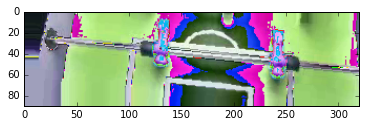

[0.5]


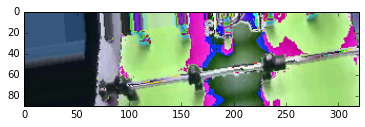

[0.0]


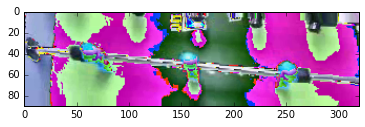

[0.0]


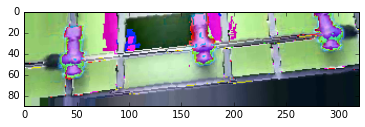

[0.5]


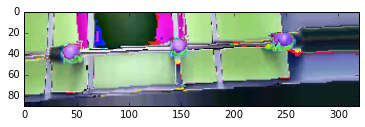

[0.0]


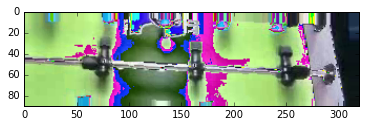

[0.5]


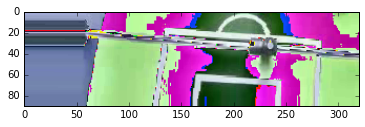

[0.0]


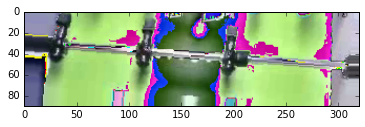

[0.5]


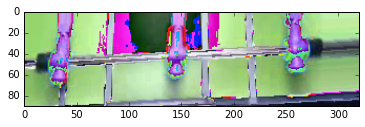

[0.5]


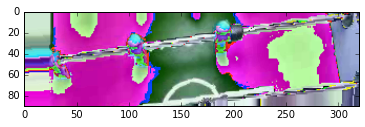

[0.0]
Shape of training input:
(1, 90, 320, 3)
Shape of training output:
(1,)
Corresponding Positions:
[0.0]


In [4]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import pandas as pd
%matplotlib inline

#training.move_first_training_frame()

for k in range(10):
    (frame, position, reset) = training.get_next_training_frame()
    data = np.zeros(shape=(np.shape(frame)[1], np.shape(frame)[2] * np.shape(frame)[0], 3), dtype=np.float32)
    for i in range(np.shape(frame)[0]):
        tmp = frame[i,:,:,:]
        data[:,i*np.shape(frame)[2]:(i+1)*np.shape(frame)[2],:] = tmp


    plt.imshow(data)
    plt.show()
    pp.pprint(position)

#training.move_first_training_frame()

print("Shape of training input:")
pp.pprint(np.shape(frame))

print("Shape of training output:")
pp.pprint(np.shape(position))

print("Corresponding Positions:")
pd.DataFrame(position)
pp.pprint(position)




# Train our model to identify the rod positions

In [5]:
from keras.models import Sequential
from keras.layers import *
from keras.models import Model


number_of_frames = 1
image_height       = training.height
image_width        = training.width
image_depth        = training.depth
image_channels     = training.channels
output_size        = 1

# Model options
batch_size = 1
cnn_kernel_count = 40

# Build the model
pp.pprint("Input shape without batches:")
pp.pprint((image_depth, image_height, image_width, image_channels))

# Used to give fixed names to the layers for transferring the model
conv_num = 0 
pool_num = 0
dense_num = 0

 # (?, 1, 90, 320, cnn_kernel_count, 3 )
# Build a functional model design
# Build a functional model design
inputs = Input(shape=(number_of_frames, image_height, image_width, image_channels,),
              name="Input")
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(inputs)
conv_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1

# Split into a horizontal detail and vertical detailed CNN paths
x = MaxPooling3D( pool_size=(1, 4, 4),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 45, 150, cnn_kernel_count, 3 )
pool_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1

x = MaxPooling3D( pool_size=(1, 4, 4),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 45, 75, 128, 3 )
pool_num+=1


x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1

x = MaxPooling3D( pool_size=(1, 1, 4),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 45, 75, 128, 3 )
pool_num+=1



x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1

x = MaxPooling3D( pool_size=(1, 2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 45, 75, 128, 3 )
pool_num+=1


x = Flatten()(x)

x = Dense(32, activation='relu',name="dense_%i"%dense_num)(x)
x = Dropout(0.5)(x)
dense_num+=1

x = Dense(16, activation='relu',name="dense_%i"%dense_num)(x)
x = Dropout(0.5)(x)
dense_num+=1

predictions = Dense(output_size, activation='linear',name="dense_%i"%dense_num)(x)
dense_num+=1


model = Model(inputs=inputs, outputs=predictions)


# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001),
              loss='mean_squared_error',
              metrics=['accuracy'])


model.summary()


'Input shape without batches:'
(1, 90, 320, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 1, 90, 320, 3)     0         
_________________________________________________________________
conv3d_0 (Conv3D)            (None, 1, 90, 320, 40)    1120      
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 1, 90, 320, 40)    14440     
_________________________________________________________________
max_pooling3d_0 (MaxPooling3 (None, 1, 22, 80, 40)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 1, 22, 80, 40)     14440     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 1, 22, 80, 40)     14440     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 

Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk0.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk0.avi
added 3204 new frames for a total of 3204
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk3.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk3.avi
added 1667 new frames for a total of 4871
Updated learner.
Batch size 1: 3897 training batches, 972 validation batches
Updated lr to 0.000200
Updated lr to 0.000177
Epoch 2/2
3897/3897 [==============================] - 93s - loss: 0.2792 - mse: 0.7117 - val_loss: 0.0599 - val_mse: 0.0599
Wrote model to .\RodAngle\angle_weights_1.hdf
Updated lr to 0.000166
Epoch 3/3
3897/3897 [==============================] - 90s - loss: 0.0675 - mse: 0.0752 - val_loss: 0.0547 - val_mse: 0.0547
Wrote model to .\RodAngle\angle_weights_2.hdf
Predicted.


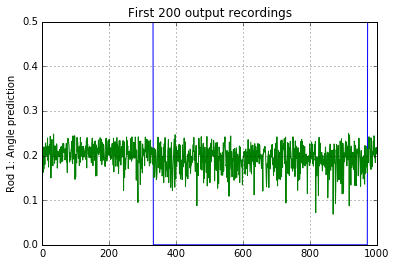

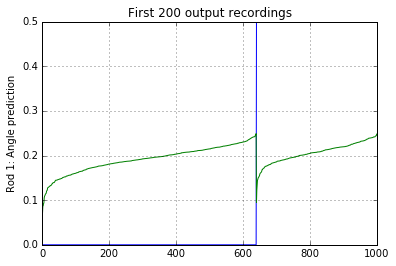

Updated lr to 0.000156
Epoch 4/4
3897/3897 [==============================] - 90s - loss: 0.0635 - mse: 0.0635 - val_loss: 0.0562 - val_mse: 0.0562
Wrote model to .\RodAngle\angle_weights_3.hdf
Updated lr to 0.000147
Epoch 5/5
3897/3897 [==============================] - 90s - loss: 0.0568 - mse: 0.0568 - val_loss: 0.0425 - val_mse: 0.0425
Wrote model to .\RodAngle\angle_weights_4.hdf
Predicted.


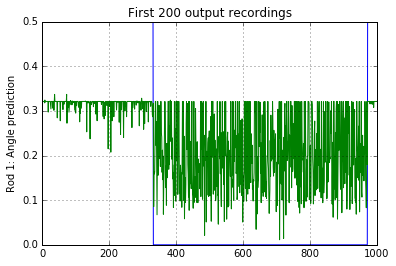

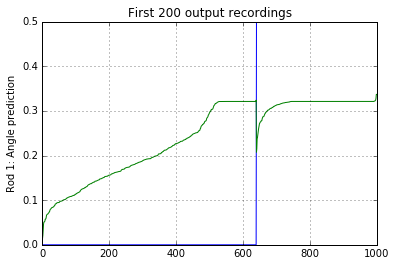

Updated lr to 0.000138
Epoch 6/6
3897/3897 [==============================] - 91s - loss: 0.0448 - mse: 0.0451 - val_loss: 0.0288 - val_mse: 0.0288
Wrote model to .\RodAngle\angle_weights_5.hdf
Updated lr to 0.000130
Epoch 7/7
3897/3897 [==============================] - 91s - loss: 0.0377 - mse: 0.0377 - val_loss: 0.0291 - val_mse: 0.0291
Wrote model to .\RodAngle\angle_weights_6.hdf
Predicted.


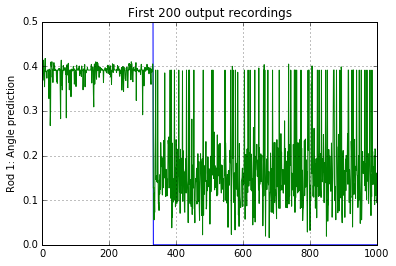

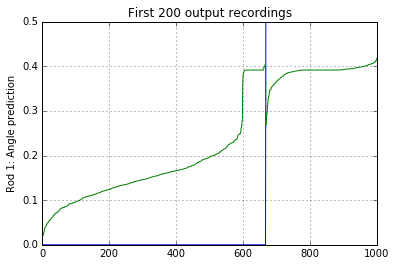

Updated lr to 0.000122
Epoch 8/8
3897/3897 [==============================] - 88s - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0456 - val_mse: 0.0456
Wrote model to .\RodAngle\angle_weights_7.hdf
Updated lr to 0.000115
Epoch 9/9
3897/3897 [==============================] - 88s - loss: 0.0304 - mse: 0.0304 - val_loss: 0.0270 - val_mse: 0.0270
Wrote model to .\RodAngle\angle_weights_8.hdf
Predicted.


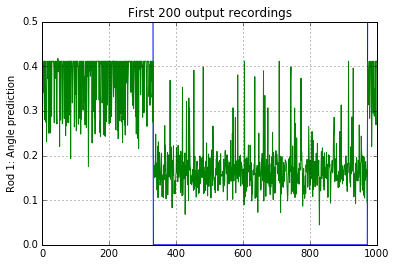

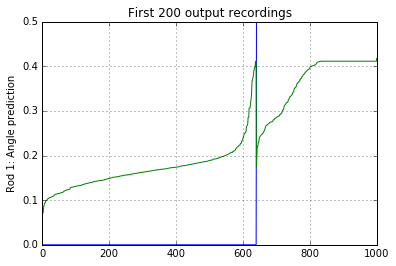

Updated lr to 0.000108
Epoch 10/10
3897/3897 [==============================] - 89s - loss: 0.0270 - mse: 0.0270 - val_loss: 0.0286 - val_mse: 0.0286
Wrote model to .\RodAngle\angle_weights_9.hdf
Predicted.


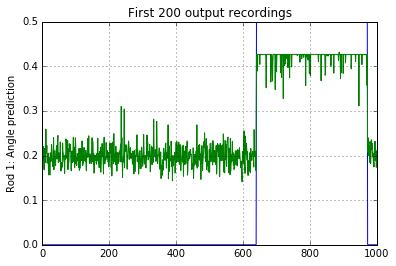

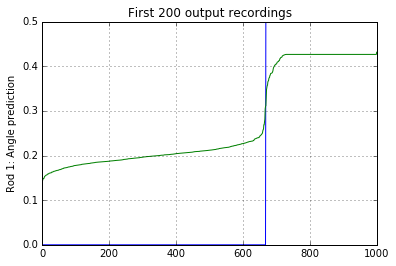

Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk0.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk0.avi
added 3204 new frames for a total of 3204
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk1.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk1.avi
added 2763 new frames for a total of 5967
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk2.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk2.avi
added 2355 new frames for a total of 8322
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk3.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk3.avi
added 1667 new frames for a total of 9989
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk4.avi
.\..\..\TrainingData\Processed\RodTrainingDataAn

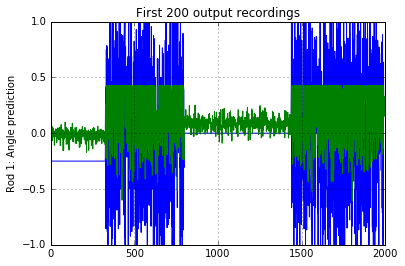

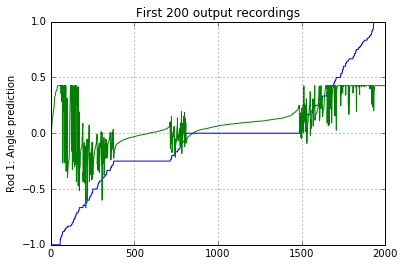

Updated lr to 0.000108
Epoch 12/12
2999/2999 [==============================] - 266s - loss: 0.0818 - mse: 0.1228 - val_loss: 0.0717 - val_mse: 0.0952
Wrote model to .\RodAngle\angle_weights_11.hdf
Updated lr to 0.000103
Epoch 13/13
2999/2999 [==============================] - 266s - loss: 0.0826 - mse: 0.1280 - val_loss: 0.1016 - val_mse: 0.1627
Wrote model to .\RodAngle\angle_weights_12.hdf
Updated lr to 0.000098
Epoch 14/14
2999/2999 [==============================] - 266s - loss: 0.0814 - mse: 0.1229 - val_loss: 0.0625 - val_mse: 0.0945
Wrote model to .\RodAngle\angle_weights_13.hdf
Updated lr to 0.000093
Epoch 15/15
2999/2999 [==============================] - 265s - loss: 0.0812 - mse: 0.1266 - val_loss: 0.0900 - val_mse: 0.1560
Wrote model to .\RodAngle\angle_weights_14.hdf
Updated lr to 0.000088
Epoch 16/16
2999/2999 [==============================] - 266s - loss: 0.0803 - mse: 0.1240 - val_loss: 0.1066 - val_mse: 0.1600
Wrote model to .\RodAngle\angle_weights_15.hdf
Updated lr

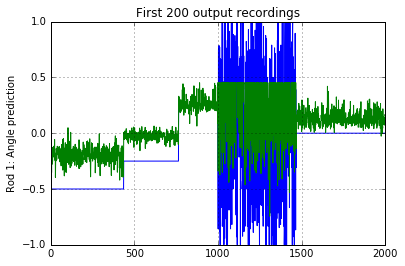

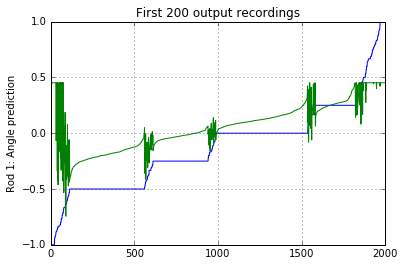

Updated lr to 0.000065
Epoch 22/22
2999/2999 [==============================] - 265s - loss: 0.0772 - mse: 0.1258 - val_loss: 0.0679 - val_mse: 0.0913
Wrote model to .\RodAngle\angle_weights_21.hdf
Updated lr to 0.000061
Epoch 23/23
2999/2999 [==============================] - 265s - loss: 0.0766 - mse: 0.1225 - val_loss: 0.0805 - val_mse: 0.1290
Wrote model to .\RodAngle\angle_weights_22.hdf
Updated lr to 0.000058
Epoch 24/24
2999/2999 [==============================] - 266s - loss: 0.0775 - mse: 0.1224 - val_loss: 0.0738 - val_mse: 0.0963
Wrote model to .\RodAngle\angle_weights_23.hdf
Updated lr to 0.000055
Epoch 25/25
2999/2999 [==============================] - 265s - loss: 0.0777 - mse: 0.1258 - val_loss: 0.0884 - val_mse: 0.1405
Wrote model to .\RodAngle\angle_weights_24.hdf
Updated lr to 0.000053
Epoch 26/26
2999/2999 [==============================] - 264s - loss: 0.0756 - mse: 0.1197 - val_loss: 0.0946 - val_mse: 0.1716
Wrote model to .\RodAngle\angle_weights_25.hdf
Updated lr

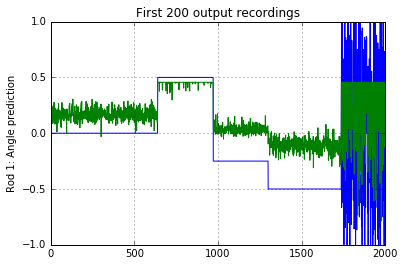

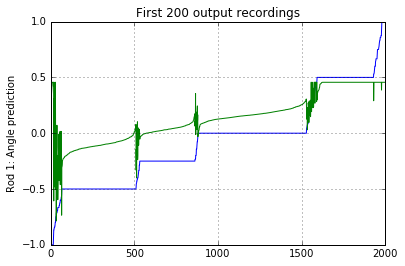

Updated lr to 0.000039
Epoch 32/32
2999/2999 [==============================] - 265s - loss: 0.0761 - mse: 0.1255 - val_loss: 0.0736 - val_mse: 0.1244
Wrote model to .\RodAngle\angle_weights_31.hdf
Updated lr to 0.000037
Epoch 33/33
2999/2999 [==============================] - 265s - loss: 0.0758 - mse: 0.1241 - val_loss: 0.1036 - val_mse: 0.1545
Wrote model to .\RodAngle\angle_weights_32.hdf
Updated lr to 0.000035
Epoch 34/34
2999/2999 [==============================] - 265s - loss: 0.0754 - mse: 0.1185 - val_loss: 0.0802 - val_mse: 0.1490
Wrote model to .\RodAngle\angle_weights_33.hdf
Updated lr to 0.000033
Epoch 35/35
2999/2999 [==============================] - 265s - loss: 0.0752 - mse: 0.1214 - val_loss: 0.0781 - val_mse: 0.1261
Wrote model to .\RodAngle\angle_weights_34.hdf
Updated lr to 0.000032
Epoch 36/36
2999/2999 [==============================] - 265s - loss: 0.0748 - mse: 0.1195 - val_loss: 0.0755 - val_mse: 0.1231
Wrote model to .\RodAngle\angle_weights_35.hdf
Updated lr

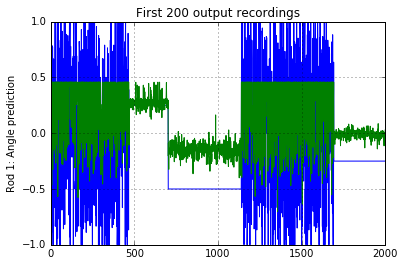

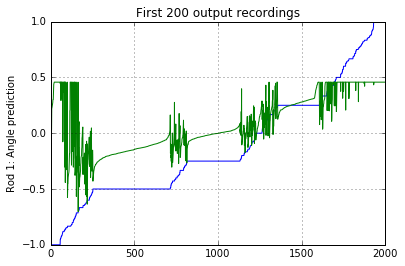

Updated lr to 0.000023
Epoch 42/42
2999/2999 [==============================] - 266s - loss: 0.0754 - mse: 0.1253 - val_loss: 0.0781 - val_mse: 0.1194
Wrote model to .\RodAngle\angle_weights_41.hdf
Updated lr to 0.000022
Epoch 43/43
2999/2999 [==============================] - 267s - loss: 0.0749 - mse: 0.1233 - val_loss: 0.0729 - val_mse: 0.0964
Wrote model to .\RodAngle\angle_weights_42.hdf
Updated lr to 0.000021
Epoch 44/44
2999/2999 [==============================] - 268s - loss: 0.0752 - mse: 0.1183 - val_loss: 0.0821 - val_mse: 0.1318
Wrote model to .\RodAngle\angle_weights_43.hdf
Updated lr to 0.000020
Epoch 45/45
2999/2999 [==============================] - 265s - loss: 0.0734 - mse: 0.1224 - val_loss: 0.0981 - val_mse: 0.1610
Wrote model to .\RodAngle\angle_weights_44.hdf
Updated lr to 0.000019
Epoch 46/46
2999/2999 [==============================] - 265s - loss: 0.0771 - mse: 0.1252 - val_loss: 0.0973 - val_mse: 0.1703
Wrote model to .\RodAngle\angle_weights_45.hdf
Updated lr

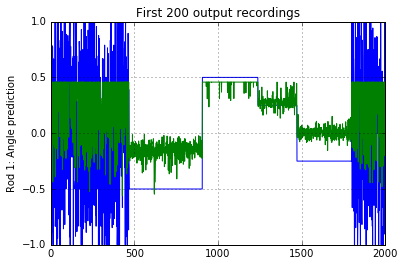

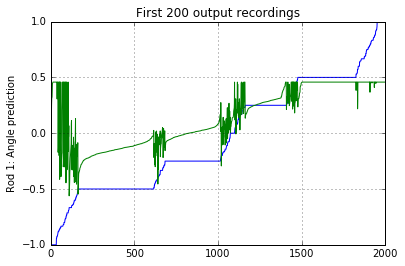

Updated lr to 0.000014
Epoch 52/52
2999/2999 [==============================] - 265s - loss: 0.0760 - mse: 0.1233 - val_loss: 0.0847 - val_mse: 0.1328
Wrote model to .\RodAngle\angle_weights_51.hdf
Updated lr to 0.000013
Epoch 53/53
2999/2999 [==============================] - 265s - loss: 0.0754 - mse: 0.1252 - val_loss: 0.0811 - val_mse: 0.1196
Wrote model to .\RodAngle\angle_weights_52.hdf
Updated lr to 0.000013
Epoch 54/54
2999/2999 [==============================] - 265s - loss: 0.0758 - mse: 0.1222 - val_loss: 0.0856 - val_mse: 0.1592
Wrote model to .\RodAngle\angle_weights_53.hdf
Updated lr to 0.000012
Epoch 55/55
2999/2999 [==============================] - 266s - loss: 0.0758 - mse: 0.1246 - val_loss: 0.0810 - val_mse: 0.1518
Wrote model to .\RodAngle\angle_weights_54.hdf
Updated lr to 0.000011
Epoch 56/56
2999/2999 [==============================] - 265s - loss: 0.0734 - mse: 0.1183 - val_loss: 0.1097 - val_mse: 0.1838
Wrote model to .\RodAngle\angle_weights_55.hdf
Updated lr

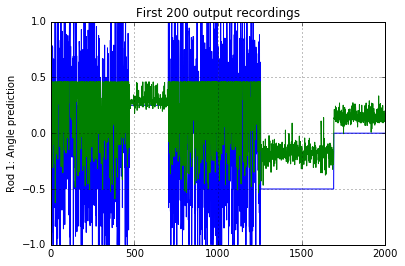

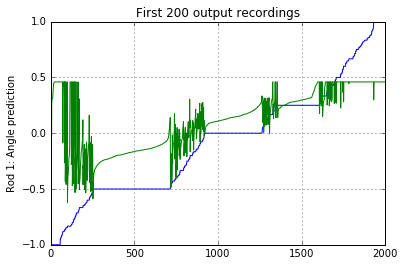

Updated lr to 0.000008
Epoch 62/62
2999/2999 [==============================] - 264s - loss: 0.0758 - mse: 0.1230 - val_loss: 0.0902 - val_mse: 0.1221
Wrote model to .\RodAngle\angle_weights_61.hdf
Updated lr to 0.000008
Epoch 63/63
2999/2999 [==============================] - 265s - loss: 0.0751 - mse: 0.1228 - val_loss: 0.0760 - val_mse: 0.1264
Wrote model to .\RodAngle\angle_weights_62.hdf
Updated lr to 0.000008
Epoch 64/64
2999/2999 [==============================] - 265s - loss: 0.0755 - mse: 0.1254 - val_loss: 0.1131 - val_mse: 0.1859
Wrote model to .\RodAngle\angle_weights_63.hdf
Updated lr to 0.000007
Epoch 65/65
2999/2999 [==============================] - 265s - loss: 0.0753 - mse: 0.1257 - val_loss: 0.0840 - val_mse: 0.1321
Wrote model to .\RodAngle\angle_weights_64.hdf
Updated lr to 0.000007
Epoch 66/66
2999/2999 [==============================] - 265s - loss: 0.0745 - mse: 0.1206 - val_loss: 0.0531 - val_mse: 0.0776
Wrote model to .\RodAngle\angle_weights_65.hdf
Updated lr

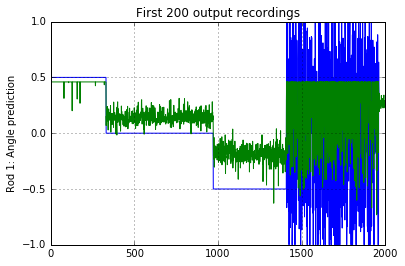

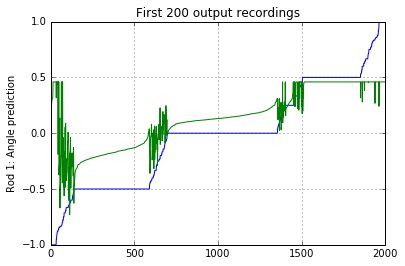

Updated lr to 0.000005
Epoch 72/72
2999/2999 [==============================] - 265s - loss: 0.0744 - mse: 0.1238 - val_loss: 0.0978 - val_mse: 0.1590
Wrote model to .\RodAngle\angle_weights_71.hdf
Updated lr to 0.000005
Epoch 73/73
2999/2999 [==============================] - 265s - loss: 0.0757 - mse: 0.1231 - val_loss: 0.0817 - val_mse: 0.1341
Wrote model to .\RodAngle\angle_weights_72.hdf
Updated lr to 0.000004
Epoch 74/74
2999/2999 [==============================] - 265s - loss: 0.0742 - mse: 0.1241 - val_loss: 0.1152 - val_mse: 0.2140
Wrote model to .\RodAngle\angle_weights_73.hdf
Updated lr to 0.000004
Epoch 75/75
2999/2999 [==============================] - 264s - loss: 0.0729 - mse: 0.1209 - val_loss: 0.0801 - val_mse: 0.1203
Wrote model to .\RodAngle\angle_weights_74.hdf
Updated lr to 0.000004
Epoch 76/76
2999/2999 [==============================] - 265s - loss: 0.0713 - mse: 0.1224 - val_loss: 0.0941 - val_mse: 0.1449
Wrote model to .\RodAngle\angle_weights_75.hdf
Updated lr

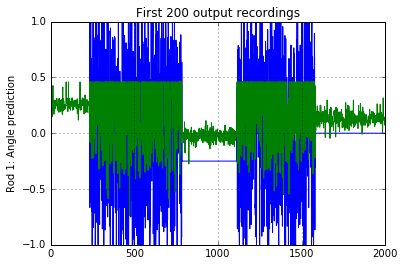

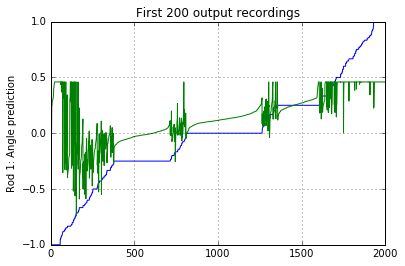

Updated lr to 0.000003
Epoch 82/82
2999/2999 [==============================] - 267s - loss: 0.0735 - mse: 0.1227 - val_loss: 0.0790 - val_mse: 0.1271
Wrote model to .\RodAngle\angle_weights_81.hdf
Updated lr to 0.000003
Epoch 83/83
2999/2999 [==============================] - 265s - loss: 0.0728 - mse: 0.1205 - val_loss: 0.0656 - val_mse: 0.0922
Wrote model to .\RodAngle\angle_weights_82.hdf
Updated lr to 0.000003
Epoch 84/84
2999/2999 [==============================] - 265s - loss: 0.0736 - mse: 0.1205 - val_loss: 0.0875 - val_mse: 0.1357
Wrote model to .\RodAngle\angle_weights_83.hdf
Updated lr to 0.000003
Epoch 85/85
2999/2999 [==============================] - 265s - loss: 0.0729 - mse: 0.1187 - val_loss: 0.0760 - val_mse: 0.1254
Wrote model to .\RodAngle\angle_weights_84.hdf
Updated lr to 0.000002
Epoch 86/86
2999/2999 [==============================] - 266s - loss: 0.0756 - mse: 0.1221 - val_loss: 0.0867 - val_mse: 0.1491
Wrote model to .\RodAngle\angle_weights_85.hdf
Updated lr

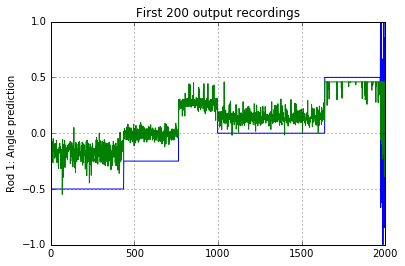

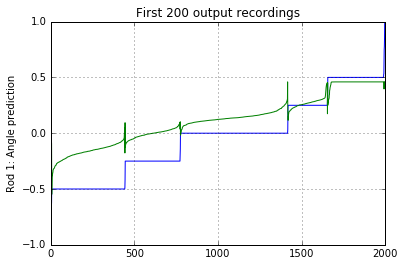

Updated lr to 0.000002
Epoch 92/92
2999/2999 [==============================] - 266s - loss: 0.0741 - mse: 0.1180 - val_loss: 0.0760 - val_mse: 0.1269
Wrote model to .\RodAngle\angle_weights_91.hdf
Updated lr to 0.000002
Epoch 93/93
2999/2999 [==============================] - 264s - loss: 0.0731 - mse: 0.1234 - val_loss: 0.0900 - val_mse: 0.1642
Wrote model to .\RodAngle\angle_weights_92.hdf
Updated lr to 0.000002
Epoch 94/94
2999/2999 [==============================] - 265s - loss: 0.0747 - mse: 0.1228 - val_loss: 0.0849 - val_mse: 0.1578
Wrote model to .\RodAngle\angle_weights_93.hdf
Updated lr to 0.000002
Epoch 95/95
2999/2999 [==============================] - 265s - loss: 0.0709 - mse: 0.1163 - val_loss: 0.0967 - val_mse: 0.1955
Wrote model to .\RodAngle\angle_weights_94.hdf
Updated lr to 0.000001
Epoch 96/96
2999/2999 [==============================] - 265s - loss: 0.0749 - mse: 0.1230 - val_loss: 0.0765 - val_mse: 0.1257
Wrote model to .\RodAngle\angle_weights_95.hdf
Updated lr

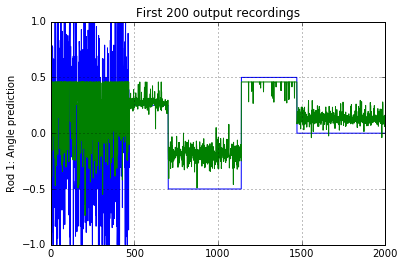

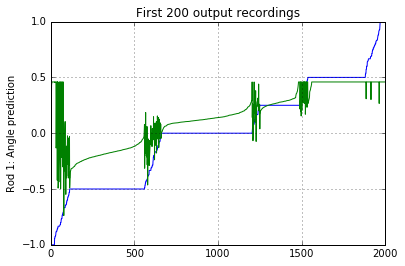

Updated lr to 0.000001
Epoch 102/102
2999/2999 [==============================] - 266s - loss: 0.0733 - mse: 0.1255 - val_loss: 0.0594 - val_mse: 0.1088
Wrote model to .\RodAngle\angle_weights_101.hdf
Updated lr to 0.000001
Epoch 103/103
2999/2999 [==============================] - 266s - loss: 0.0756 - mse: 0.1235 - val_loss: 0.0711 - val_mse: 0.1202
Wrote model to .\RodAngle\angle_weights_102.hdf
Updated lr to 0.000001
Epoch 104/104
2999/2999 [==============================] - 266s - loss: 0.0728 - mse: 0.1205 - val_loss: 0.0978 - val_mse: 0.1716
Wrote model to .\RodAngle\angle_weights_103.hdf
Updated lr to 0.000001
Epoch 105/105
2999/2999 [==============================] - 266s - loss: 0.0739 - mse: 0.1217 - val_loss: 0.0587 - val_mse: 0.0840
Wrote model to .\RodAngle\angle_weights_104.hdf
Updated lr to 0.000001
Epoch 106/106
2999/2999 [==============================] - 266s - loss: 0.0753 - mse: 0.1271 - val_loss: 0.0417 - val_mse: 0.0656
Wrote model to .\RodAngle\angle_weights_105

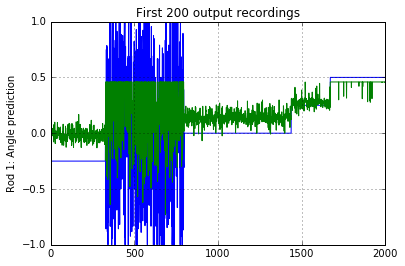

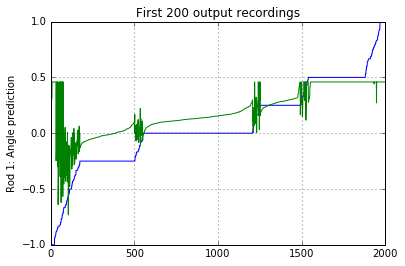

Updated lr to 0.000001
Epoch 112/112
2999/2999 [==============================] - 266s - loss: 0.0740 - mse: 0.1188 - val_loss: 0.0665 - val_mse: 0.1178
Wrote model to .\RodAngle\angle_weights_111.hdf
Updated lr to 0.000001
Epoch 113/113
2999/2999 [==============================] - 268s - loss: 0.0731 - mse: 0.1210 - val_loss: 0.1060 - val_mse: 0.1794
Wrote model to .\RodAngle\angle_weights_112.hdf
Updated lr to 0.000001
Epoch 114/114
2999/2999 [==============================] - 266s - loss: 0.0741 - mse: 0.1240 - val_loss: 0.1028 - val_mse: 0.1758
Wrote model to .\RodAngle\angle_weights_113.hdf
Updated lr to 0.000001
Epoch 115/115
2999/2999 [==============================] - 265s - loss: 0.0751 - mse: 0.1229 - val_loss: 0.0916 - val_mse: 0.1415
Wrote model to .\RodAngle\angle_weights_114.hdf
Updated lr to 0.000001
Epoch 116/116
2999/2999 [==============================] - 266s - loss: 0.0727 - mse: 0.1217 - val_loss: 0.0516 - val_mse: 0.0877
Wrote model to .\RodAngle\angle_weights_115

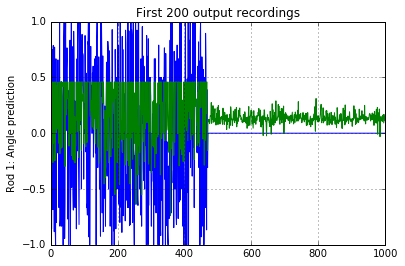

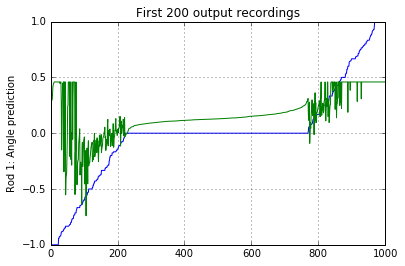

In [6]:


def mse_wrap(y_true, y_pred):
    # This is a rapped MSE function, since -1 is the same as 1 for rod rotation.
    return K.square( K.min( K.abs( K.concatenate([y_pred - y_true, y_pred - y_true + 2, y_pred - y_true -2])), axis=1 ) )

def mse(y_true, y_pred):
    return K.square(y_pred - y_true)


data_path  = ".\\..\\..\\TrainingData\\Processed\\RodTrainingDataAngles\\Result\\settings_just_two.tsv"
transformer = VideoTransform( zoom_range=0.1, rotation_range=5, width_shift_range=0.1, height_shift_range=0.1, shear_range= 0.1, fill_mode='nearest', vertical_flip=False, horizontal_flip=True, horizontal_flip_invert_indices = [], horizontal_flip_reverse_indices = [], data_format='channels_last' )
training = TrainingInput(transformer, data_path, position_rel_indexes, frame_rel_indexes, 0.20)

model.compile(optimizer=keras.optimizers.RMSprop(lr=0.001),
              loss=[mse],
              metrics=[mse])

print("Updated learner.")

WEIGHTS_FNAME = '.\\RodAngle\\angle_weights_%i.hdf'
MODELS_FNAME = '.\\RodAngle\\angle_models_%i.h5'

batch_size = 1
batches_training_per_epoch = int(training.get_training_count() / batch_size)
batches_validation_per_epoch = int(training.get_validation_count() / batch_size)
print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )

epoch = 0
model.reset_states()


lr = 0.0002
lr_decay =  lr_decay_callback(lr, 0.94)


print("Updated lr to %f" % lr)
model.compile(optimizer=keras.optimizers.RMSprop(lr=lr),
              loss=[mse_wrap],
              metrics=[mse])

start_epoch = epoch + 1
for epoch in range(start_epoch,10):
    try:
        model.fit_generator(TrainBatchGen(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch, callbacks=[lr_decay])
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
        plot_validate(ValidateBatchGen(batch_size, model, training), model, 1000, "Angle prediction")   
        
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        break


# Plot the real versus predicted values for some of the validation data
plot_validate(ValidateBatchGen(batch_size, model, training), model, 1000, "Angle prediction") 


data_path  = ".\\..\\..\\TrainingData\\Processed\\RodTrainingDataAngles\\Result\\settings_full.tsv"
transformer = VideoTransform( zoom_range=0.1, rotation_range=5, width_shift_range=0.1, height_shift_range=0.1, shear_range= 0.1, fill_mode='nearest', vertical_flip=False, horizontal_flip=True, horizontal_flip_invert_indices = [], horizontal_flip_reverse_indices = [], data_format='channels_last' )
training = TrainingInput(transformer, data_path, position_rel_indexes, frame_rel_indexes, 0.20)

batch_size = 4
batches_training_per_epoch = int(training.get_training_count() / batch_size)
batches_validation_per_epoch = int(training.get_validation_count() / batch_size)
print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )

lr = 0.0002
lr_decay =  lr_decay_callback(lr, 0.95)
print("Updated lr to %f" % lr)

model.compile(optimizer=keras.optimizers.RMSprop(lr=lr),
              loss=[mse_wrap],
              metrics=[mse])

epoch = 0
start_epoch = epoch + 1
for epoch in range(start_epoch,2000):
    try:
        model.fit_generator(TrainBatchGen(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch, callbacks=[lr_decay])
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
        
        if epoch % 10 == 0:
            plot_validate(ValidateBatchGen(batch_size, model, training), model, 2000, "Angle prediction")   
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        break

plot_validate(ValidateBatchGen(batch_size, model, training), model, 1000, "Angle prediction")   



Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk0.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk0.avi
added 3204 new frames for a total of 3204
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk1.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk1.avi
added 2763 new frames for a total of 5967
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk2.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk2.avi
added 2355 new frames for a total of 8322
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk3.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk3.avi
added 1667 new frames for a total of 9989
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk4.avi
.\..\..\TrainingData\Processed\RodTrainingDataAn

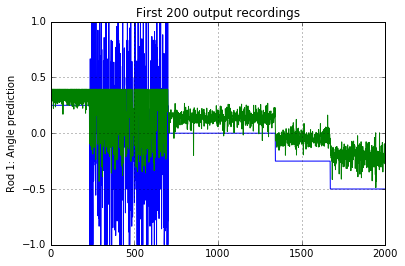

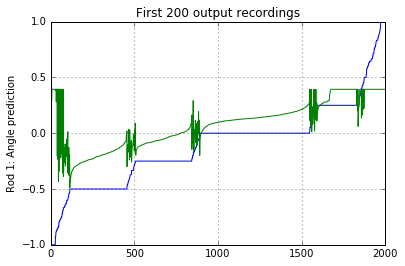

Updated lr to 0.000139
Epoch 12/12
2999/2999 [==============================] - 266s - loss: 0.0854 - mse: 0.1241 - val_loss: 0.0937 - val_mse: 0.1464
Wrote model to .\RodAngle\angle_weights_11.hdf
Updated lr to 0.000135
Epoch 13/13
2999/2999 [==============================] - 266s - loss: 0.0889 - mse: 0.1350 - val_loss: 0.1066 - val_mse: 0.1754
Wrote model to .\RodAngle\angle_weights_12.hdf
Updated lr to 0.000131
Epoch 14/14
2999/2999 [==============================] - 266s - loss: 0.0862 - mse: 0.1280 - val_loss: 0.0958 - val_mse: 0.1449
Wrote model to .\RodAngle\angle_weights_13.hdf
Updated lr to 0.000127
Epoch 15/15
2999/2999 [==============================] - 267s - loss: 0.0912 - mse: 0.1426 - val_loss: 0.1179 - val_mse: 0.2124
Wrote model to .\RodAngle\angle_weights_14.hdf
Updated lr to 0.000123
Epoch 16/16
2999/2999 [==============================] - 266s - loss: 0.0867 - mse: 0.1321 - val_loss: 0.0670 - val_mse: 0.1151
Wrote model to .\RodAngle\angle_weights_15.hdf
Updated lr

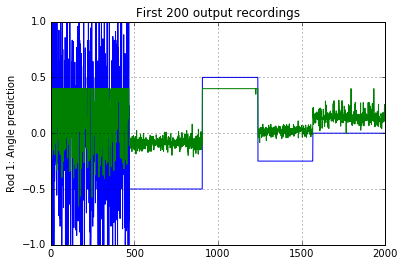

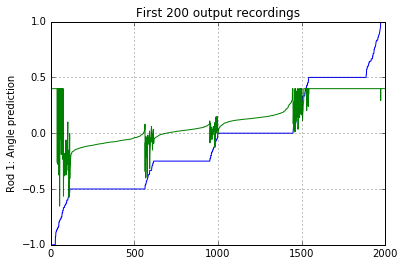

Updated lr to 0.000102
Epoch 22/22
2999/2999 [==============================] - 268s - loss: 0.0833 - mse: 0.1249 - val_loss: 0.0627 - val_mse: 0.0638
Wrote model to .\RodAngle\angle_weights_21.hdf
Updated lr to 0.000099
Epoch 23/23
2999/2999 [==============================] - 268s - loss: 0.0862 - mse: 0.1242 - val_loss: 0.1012 - val_mse: 0.1378
Wrote model to .\RodAngle\angle_weights_22.hdf
Updated lr to 0.000096
Epoch 24/24
2999/2999 [==============================] - 265s - loss: 0.0838 - mse: 0.1292 - val_loss: 0.0879 - val_mse: 0.1571
Wrote model to .\RodAngle\angle_weights_23.hdf
Updated lr to 0.000093
Epoch 25/25
2999/2999 [==============================] - 266s - loss: 0.0820 - mse: 0.1276 - val_loss: 0.0750 - val_mse: 0.1189
Wrote model to .\RodAngle\angle_weights_24.hdf
Updated lr to 0.000091
Epoch 26/26
2999/2999 [==============================] - 266s - loss: 0.0832 - mse: 0.1244 - val_loss: 0.0945 - val_mse: 0.1393
Wrote model to .\RodAngle\angle_weights_25.hdf
Updated lr

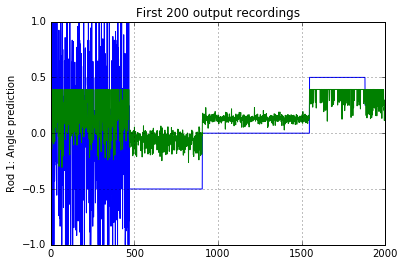

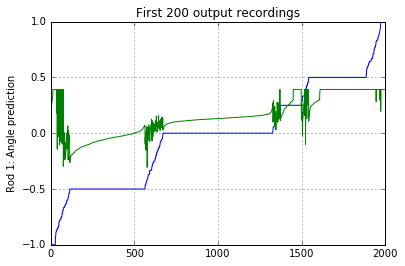

Updated lr to 0.000075
Epoch 32/32
2999/2999 [==============================] - 266s - loss: 0.0820 - mse: 0.1236 - val_loss: 0.0986 - val_mse: 0.1703
Wrote model to .\RodAngle\angle_weights_31.hdf
Updated lr to 0.000073
Epoch 33/33
2999/2999 [==============================] - 266s - loss: 0.0838 - mse: 0.1264 - val_loss: 0.0730 - val_mse: 0.1222
Wrote model to .\RodAngle\angle_weights_32.hdf
Updated lr to 0.000071
Epoch 34/34
2999/2999 [==============================] - 266s - loss: 0.0809 - mse: 0.1199 - val_loss: 0.0939 - val_mse: 0.1344
Wrote model to .\RodAngle\angle_weights_33.hdf
Updated lr to 0.000069
Epoch 35/35
2999/2999 [==============================] - 268s - loss: 0.0823 - mse: 0.1201 - val_loss: 0.0771 - val_mse: 0.1197
Wrote model to .\RodAngle\angle_weights_34.hdf
Updated lr to 0.000067
Epoch 36/36
2999/2999 [==============================] - 266s - loss: 0.0807 - mse: 0.1225 - val_loss: 0.0758 - val_mse: 0.1121
Wrote model to .\RodAngle\angle_weights_35.hdf
Updated lr

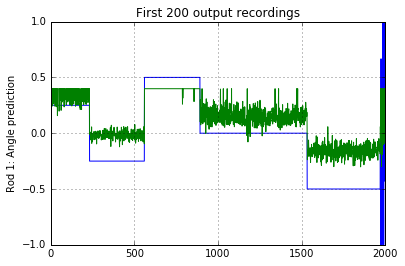

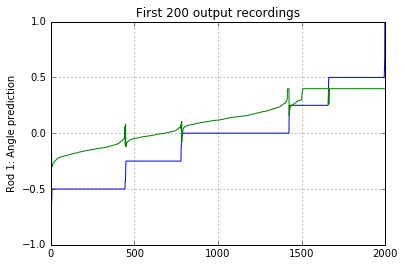

Updated lr to 0.000056
Epoch 42/42
2999/2999 [==============================] - 266s - loss: 0.0817 - mse: 0.1262 - val_loss: 0.0890 - val_mse: 0.1616
Wrote model to .\RodAngle\angle_weights_41.hdf
Updated lr to 0.000054
Epoch 43/43
2999/2999 [==============================] - 266s - loss: 0.0839 - mse: 0.1303 - val_loss: 0.0992 - val_mse: 0.1645
Wrote model to .\RodAngle\angle_weights_42.hdf
Updated lr to 0.000052
Epoch 44/44
2999/2999 [==============================] - 266s - loss: 0.0795 - mse: 0.1180 - val_loss: 0.0828 - val_mse: 0.1317
Wrote model to .\RodAngle\angle_weights_43.hdf
Updated lr to 0.000051
Epoch 45/45
2999/2999 [==============================] - 266s - loss: 0.0805 - mse: 0.1215 - val_loss: 0.0921 - val_mse: 0.1599
Wrote model to .\RodAngle\angle_weights_44.hdf
Updated lr to 0.000049
Epoch 46/46
2999/2999 [==============================] - 266s - loss: 0.0816 - mse: 0.1221 - val_loss: 0.0854 - val_mse: 0.1334
Wrote model to .\RodAngle\angle_weights_45.hdf
Updated lr

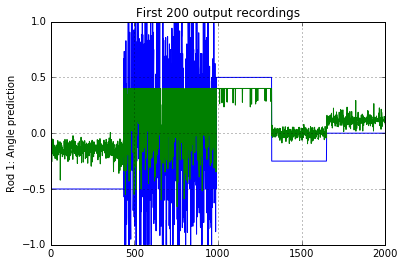

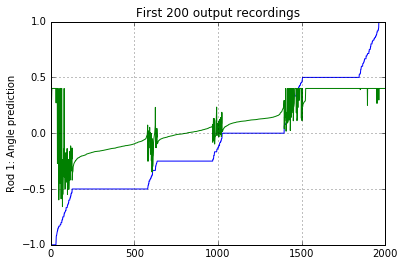

Updated lr to 0.000041
Epoch 52/52
2999/2999 [==============================] - 268s - loss: 0.0803 - mse: 0.1220 - val_loss: 0.0983 - val_mse: 0.1421
Wrote model to .\RodAngle\angle_weights_51.hdf
Updated lr to 0.000040
Epoch 53/53
2999/2999 [==============================] - 266s - loss: 0.0803 - mse: 0.1251 - val_loss: 0.0842 - val_mse: 0.1303
Wrote model to .\RodAngle\angle_weights_52.hdf
Updated lr to 0.000039
Epoch 54/54
2999/2999 [==============================] - 267s - loss: 0.0813 - mse: 0.1213 - val_loss: 0.1027 - val_mse: 0.1525
Wrote model to .\RodAngle\angle_weights_53.hdf
Updated lr to 0.000037
Epoch 55/55
2999/2999 [==============================] - 266s - loss: 0.0808 - mse: 0.1234 - val_loss: 0.1121 - val_mse: 0.1627
Wrote model to .\RodAngle\angle_weights_54.hdf
Updated lr to 0.000036
Epoch 56/56
2999/2999 [==============================] - 266s - loss: 0.0801 - mse: 0.1225 - val_loss: 0.0668 - val_mse: 0.1140
Wrote model to .\RodAngle\angle_weights_55.hdf
Updated lr

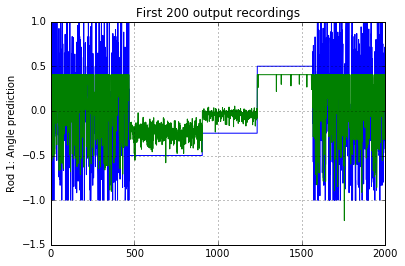

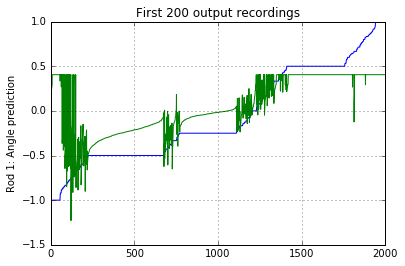

Updated lr to 0.000030
Epoch 62/62
2999/2999 [==============================] - 265s - loss: 0.0830 - mse: 0.1287 - val_loss: 0.0730 - val_mse: 0.1194
Wrote model to .\RodAngle\angle_weights_61.hdf
Updated lr to 0.000029
Epoch 63/63
2999/2999 [==============================] - 266s - loss: 0.0790 - mse: 0.1258 - val_loss: 0.0636 - val_mse: 0.1096
Wrote model to .\RodAngle\angle_weights_62.hdf
Updated lr to 0.000028
Epoch 64/64
2999/2999 [==============================] - 266s - loss: 0.0774 - mse: 0.1151 - val_loss: 0.0659 - val_mse: 0.0892
Wrote model to .\RodAngle\angle_weights_63.hdf
Updated lr to 0.000028
Epoch 65/65
2999/2999 [==============================] - 265s - loss: 0.0793 - mse: 0.1225 - val_loss: 0.0905 - val_mse: 0.1361
Wrote model to .\RodAngle\angle_weights_64.hdf
Updated lr to 0.000027
Epoch 66/66
2999/2999 [==============================] - 266s - loss: 0.0769 - mse: 0.1179 - val_loss: 0.0929 - val_mse: 0.1379
Wrote model to .\RodAngle\angle_weights_65.hdf
Updated lr

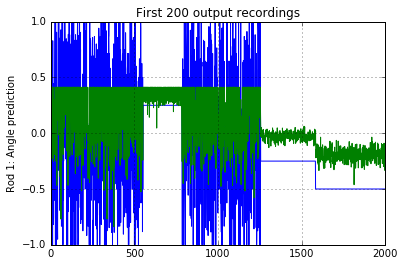

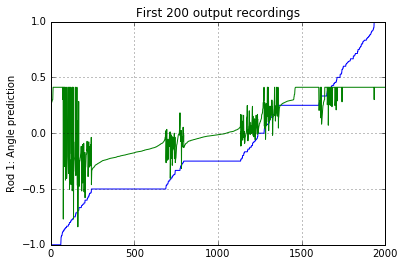

Updated lr to 0.000022
Epoch 72/72
2999/2999 [==============================] - 265s - loss: 0.0776 - mse: 0.1203 - val_loss: 0.0998 - val_mse: 0.1406
Wrote model to .\RodAngle\angle_weights_71.hdf
Updated lr to 0.000022
Epoch 73/73
2999/2999 [==============================] - 266s - loss: 0.0761 - mse: 0.1144 - val_loss: 0.0860 - val_mse: 0.1326
Wrote model to .\RodAngle\angle_weights_72.hdf
Updated lr to 0.000021
Epoch 74/74
2999/2999 [==============================] - 267s - loss: 0.0785 - mse: 0.1215 - val_loss: 0.0892 - val_mse: 0.1356
Wrote model to .\RodAngle\angle_weights_73.hdf
Updated lr to 0.000020
Epoch 75/75
2999/2999 [==============================] - 266s - loss: 0.0781 - mse: 0.1189 - val_loss: 0.1163 - val_mse: 0.2083
Wrote model to .\RodAngle\angle_weights_74.hdf
Updated lr to 0.000020
Epoch 76/76
2999/2999 [==============================] - 266s - loss: 0.0788 - mse: 0.1214 - val_loss: 0.0912 - val_mse: 0.1481
Wrote model to .\RodAngle\angle_weights_75.hdf
Updated lr

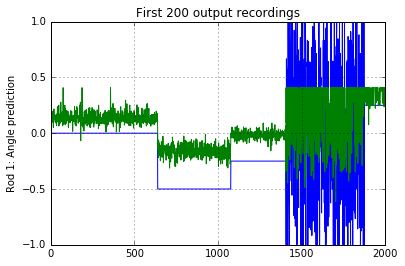

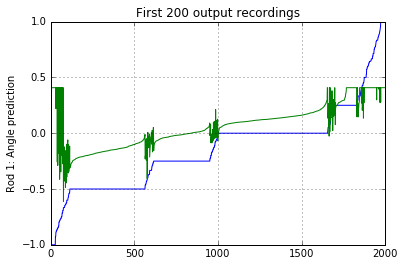

Updated lr to 0.000016
Epoch 82/82
2999/2999 [==============================] - 266s - loss: 0.0785 - mse: 0.1222 - val_loss: 0.0848 - val_mse: 0.1339
Wrote model to .\RodAngle\angle_weights_81.hdf
Updated lr to 0.000016
Epoch 83/83
2999/2999 [==============================] - 265s - loss: 0.0809 - mse: 0.1290 - val_loss: 0.0579 - val_mse: 0.1022
Wrote model to .\RodAngle\angle_weights_82.hdf
Updated lr to 0.000015
Epoch 84/84
2999/2999 [==============================] - 265s - loss: 0.0845 - mse: 0.1364 - val_loss: 0.0678 - val_mse: 0.1124
Wrote model to .\RodAngle\angle_weights_83.hdf
Updated lr to 0.000015
Epoch 85/85
2999/2999 [==============================] - 266s - loss: 0.0780 - mse: 0.1195 - val_loss: 0.0819 - val_mse: 0.1395
Wrote model to .\RodAngle\angle_weights_84.hdf
Updated lr to 0.000015
Epoch 86/86
2999/2999 [==============================] - 266s - loss: 0.0782 - mse: 0.1201 - val_loss: 0.0669 - val_mse: 0.1150
Wrote model to .\RodAngle\angle_weights_85.hdf
Updated lr

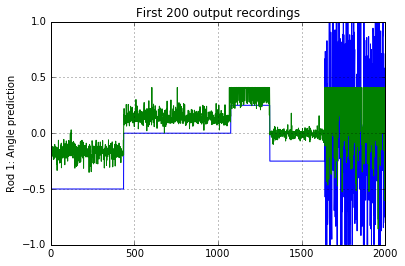

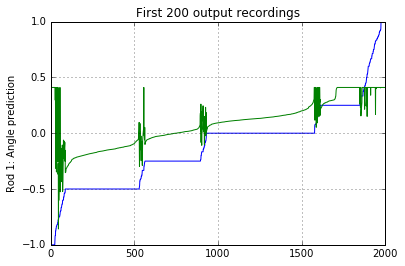

Updated lr to 0.000012
Epoch 92/92
2999/2999 [==============================] - 266s - loss: 0.0812 - mse: 0.1288 - val_loss: 0.0978 - val_mse: 0.1647
Wrote model to .\RodAngle\angle_weights_91.hdf
Updated lr to 0.000012
Epoch 93/93
2999/2999 [==============================] - 266s - loss: 0.0951 - mse: 0.1421 - val_loss: 0.0716 - val_mse: 0.1132
Wrote model to .\RodAngle\angle_weights_92.hdf
Updated lr to 0.000011
Epoch 94/94
2999/2999 [==============================] - 265s - loss: 0.0757 - mse: 0.1166 - val_loss: 0.0639 - val_mse: 0.1109
Wrote model to .\RodAngle\angle_weights_93.hdf
Updated lr to 0.000011
Epoch 95/95
2999/2999 [==============================] - 266s - loss: 0.0789 - mse: 0.1251 - val_loss: 0.0513 - val_mse: 0.0738
Wrote model to .\RodAngle\angle_weights_94.hdf
Updated lr to 0.000011
Epoch 96/96
2999/2999 [==============================] - 266s - loss: 0.0764 - mse: 0.1207 - val_loss: 0.0884 - val_mse: 0.1509
Wrote model to .\RodAngle\angle_weights_95.hdf
Updated lr

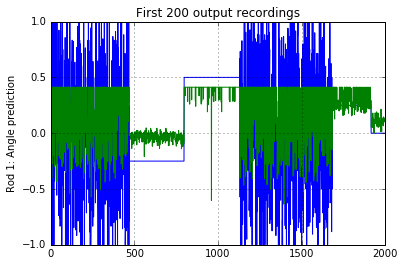

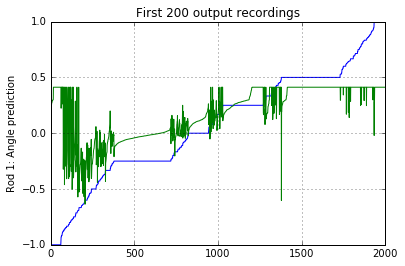

Updated lr to 0.000009
Epoch 102/102
2999/2999 [==============================] - 265s - loss: 0.0761 - mse: 0.1180 - val_loss: 0.0832 - val_mse: 0.1525
Wrote model to .\RodAngle\angle_weights_101.hdf
Updated lr to 0.000009
Epoch 103/103
2999/2999 [==============================] - 266s - loss: 0.0771 - mse: 0.1228 - val_loss: 0.0911 - val_mse: 0.1355
Wrote model to .\RodAngle\angle_weights_102.hdf
Updated lr to 0.000008
Epoch 104/104
2999/2999 [==============================] - 267s - loss: 0.0770 - mse: 0.1173 - val_loss: 0.0839 - val_mse: 0.1506
Wrote model to .\RodAngle\angle_weights_103.hdf
Updated lr to 0.000008
Epoch 105/105
2999/2999 [==============================] - 266s - loss: 0.0760 - mse: 0.1242 - val_loss: 0.0752 - val_mse: 0.1247
Wrote model to .\RodAngle\angle_weights_104.hdf
Updated lr to 0.000008
Epoch 106/106
2999/2999 [==============================] - 266s - loss: 0.0746 - mse: 0.1136 - val_loss: 0.0710 - val_mse: 0.0934
Wrote model to .\RodAngle\angle_weights_105

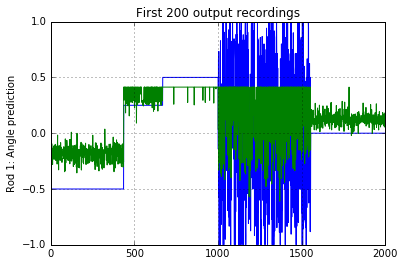

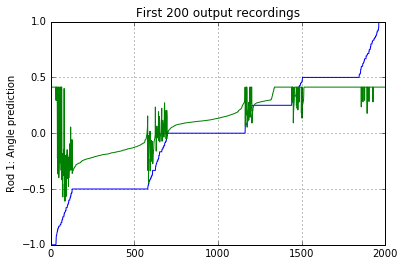

Updated lr to 0.000007
Epoch 112/112
2999/2999 [==============================] - 269s - loss: 0.0864 - mse: 0.1351 - val_loss: 0.0711 - val_mse: 0.1166
Wrote model to .\RodAngle\angle_weights_111.hdf
Updated lr to 0.000006
Epoch 113/113
2999/2999 [==============================] - 265s - loss: 0.0749 - mse: 0.1191 - val_loss: 0.1076 - val_mse: 0.1778
Wrote model to .\RodAngle\angle_weights_112.hdf
Updated lr to 0.000006
Epoch 114/114
2999/2999 [==============================] - 269s - loss: 0.0753 - mse: 0.1160 - val_loss: 0.0588 - val_mse: 0.0818
Wrote model to .\RodAngle\angle_weights_113.hdf
Updated lr to 0.000006
Epoch 115/115
2999/2999 [==============================] - 268s - loss: 0.0772 - mse: 0.1226 - val_loss: 0.0593 - val_mse: 0.0933
Wrote model to .\RodAngle\angle_weights_114.hdf
Updated lr to 0.000006
Epoch 116/116
2999/2999 [==============================] - 266s - loss: 0.0754 - mse: 0.1175 - val_loss: 0.0582 - val_mse: 0.0850
Wrote model to .\RodAngle\angle_weights_115

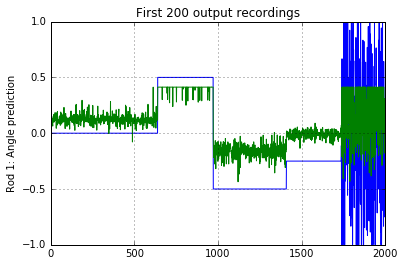

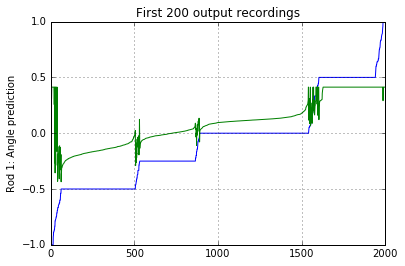

Updated lr to 0.000005
Epoch 122/122
2999/2999 [==============================] - 266s - loss: 0.0762 - mse: 0.1186 - val_loss: 0.0482 - val_mse: 0.0726
Wrote model to .\RodAngle\angle_weights_121.hdf
Updated lr to 0.000005
Epoch 123/123
2999/2999 [==============================] - 267s - loss: 0.0773 - mse: 0.1235 - val_loss: 0.0962 - val_mse: 0.1749
Wrote model to .\RodAngle\angle_weights_122.hdf
Updated lr to 0.000005
Epoch 124/124
2999/2999 [==============================] - 266s - loss: 0.0761 - mse: 0.1182 - val_loss: 0.0915 - val_mse: 0.1374
Wrote model to .\RodAngle\angle_weights_123.hdf
Updated lr to 0.000004
Epoch 125/125
2999/2999 [==============================] - 266s - loss: 0.0762 - mse: 0.1180 - val_loss: 0.0761 - val_mse: 0.1216
Wrote model to .\RodAngle\angle_weights_124.hdf
Updated lr to 0.000004
Epoch 126/126
2999/2999 [==============================] - 267s - loss: 0.0815 - mse: 0.1316 - val_loss: 0.0761 - val_mse: 0.1226
Wrote model to .\RodAngle\angle_weights_125

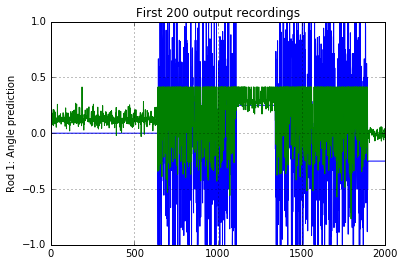

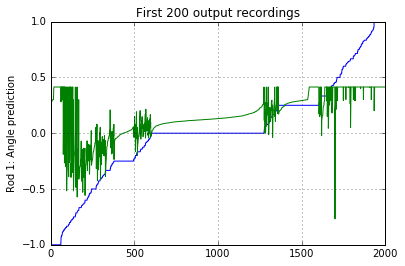

Updated lr to 0.000004
Epoch 132/132
2999/2999 [==============================] - 301s - loss: 0.0787 - mse: 0.1219 - val_loss: 0.0633 - val_mse: 0.0856
Wrote model to .\RodAngle\angle_weights_131.hdf
Updated lr to 0.000003
Epoch 133/133
2999/2999 [==============================] - 263s - loss: 0.0760 - mse: 0.1215 - val_loss: 0.0904 - val_mse: 0.1405
Wrote model to .\RodAngle\angle_weights_132.hdf
Updated lr to 0.000003
Epoch 134/134
2999/2999 [==============================] - 264s - loss: 0.0761 - mse: 0.1185 - val_loss: 0.1025 - val_mse: 0.1710
Wrote model to .\RodAngle\angle_weights_133.hdf
Updated lr to 0.000003
Epoch 135/135
2999/2999 [==============================] - 268s - loss: 0.0756 - mse: 0.1191 - val_loss: 0.0600 - val_mse: 0.0708
Wrote model to .\RodAngle\angle_weights_134.hdf
Updated lr to 0.000003
Epoch 136/136
2999/2999 [==============================] - 262s - loss: 0.1421 - mse: 0.1947 - val_loss: 0.0719 - val_mse: 0.1152
Wrote model to .\RodAngle\angle_weights_135

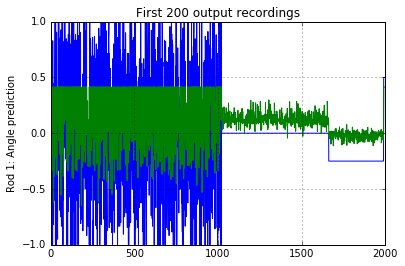

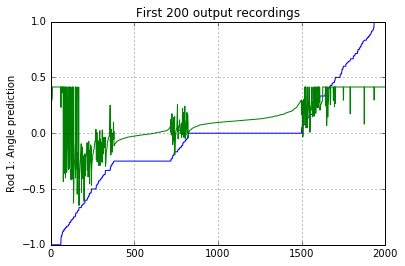

Updated lr to 0.000003
Epoch 142/142
2999/2999 [==============================] - 263s - loss: 0.0745 - mse: 0.1185 - val_loss: 0.0862 - val_mse: 0.1355
Wrote model to .\RodAngle\angle_weights_141.hdf
Updated lr to 0.000003
Epoch 143/143
2999/2999 [==============================] - 263s - loss: 0.0793 - mse: 0.1291 - val_loss: 0.1119 - val_mse: 0.1843
Wrote model to .\RodAngle\angle_weights_142.hdf
Updated lr to 0.000002
Epoch 144/144
2999/2999 [==============================] - 263s - loss: 0.0753 - mse: 0.1179 - val_loss: 0.0830 - val_mse: 0.1253
Wrote model to .\RodAngle\angle_weights_143.hdf
Updated lr to 0.000002
Epoch 145/145
2999/2999 [==============================] - 263s - loss: 0.0763 - mse: 0.1231 - val_loss: 0.0843 - val_mse: 0.1306
Wrote model to .\RodAngle\angle_weights_144.hdf
Updated lr to 0.000002
Epoch 146/146
2999/2999 [==============================] - 262s - loss: 0.0965 - mse: 0.1514 - val_loss: 0.0714 - val_mse: 0.0959
Wrote model to .\RodAngle\angle_weights_145

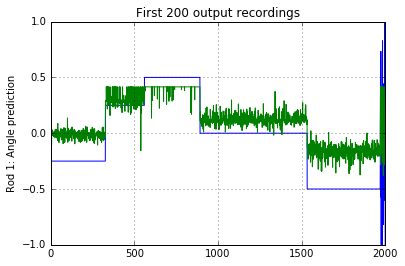

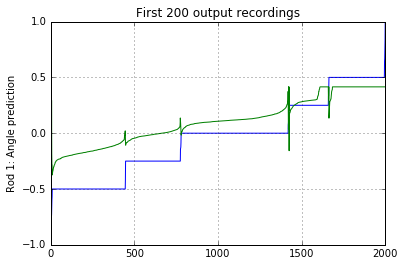

Updated lr to 0.000002
Epoch 152/152
2226/2999 [=====================>........] - ETA: 55s - loss: 0.0759 - mse: 0.1184
User stopped the training.


In [ ]:
data_path  = ".\\..\\..\\TrainingData\\Processed\\RodTrainingDataAngles\\Result\\settings_full.tsv"
transformer = VideoTransform( zoom_range=0.1, rotation_range=5, width_shift_range=0.1, height_shift_range=0.1, shear_range= 0.1, fill_mode='nearest', vertical_flip=False, horizontal_flip=True, horizontal_flip_invert_indices = [], horizontal_flip_reverse_indices = [], data_format='channels_last' )
training = TrainingInput(transformer, data_path, position_rel_indexes, frame_rel_indexes, 0.20)

batch_size = 4
batches_training_per_epoch = int(training.get_training_count() / batch_size)
batches_validation_per_epoch = int(training.get_validation_count() / batch_size)
print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )

lr = 0.0002
lr_decay =  lr_decay_callback(lr, 0.97)
print("Updated lr to %f" % lr)

model.compile(optimizer=keras.optimizers.RMSprop(lr=lr),
              loss=[mse_wrap],
              metrics=[mse])

epoch = 0
start_epoch = epoch + 1
for epoch in range(start_epoch,2000):
    try:
        model.fit_generator(TrainBatchGen(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch, callbacks=[lr_decay])
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
        
        if epoch % 10 == 0:
            plot_validate(ValidateBatchGen(batch_size, model, training), model, 2000, "Angle prediction")   
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        break

plot_validate(ValidateBatchGen(batch_size, model, training), model, 2000, "Angle prediction")   

Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk0.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk0.avi
added 3204 new frames for a total of 3204
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk1.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk1.avi
added 2763 new frames for a total of 5967
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk2.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk2.avi
added 2355 new frames for a total of 8322
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk3.avi
.\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk3.avi
added 1667 new frames for a total of 9989
Creating training chunk from .\..\..\TrainingData\Processed\RodTrainingDataAngles\Result\chunk4.avi
.\..\..\TrainingData\Processed\RodTrainingDataAn

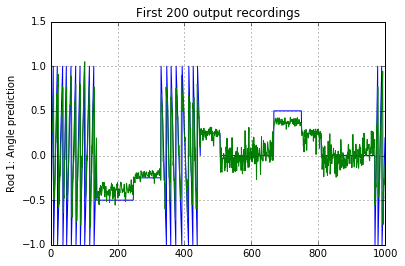

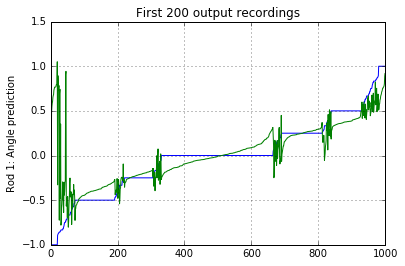

Epoch 66/66
1157/1157 [==============================] - 93s - loss: 0.0502 - mse: 0.1375 - val_loss: 0.0144 - val_mse: 0.0144
Wrote model to .\RodAngle\angle_weights_65.hdf
Epoch 67/67
1157/1157 [==============================] - 96s - loss: 0.0486 - mse: 0.1435 - val_loss: 0.0165 - val_mse: 0.0165
Wrote model to .\RodAngle\angle_weights_66.hdf
Epoch 68/68
1157/1157 [==============================] - 97s - loss: 0.0500 - mse: 0.1362 - val_loss: 0.0100 - val_mse: 0.0100
Wrote model to .\RodAngle\angle_weights_67.hdf
Epoch 69/69
1157/1157 [==============================] - 89s - loss: 0.0511 - mse: 0.1480 - val_loss: 0.0160 - val_mse: 0.0808
Wrote model to .\RodAngle\angle_weights_68.hdf
Predicted.
array([[-1.        ],
       [-0.75      ],
       [-0.5       ],
       [-0.25      ],
       [ 0.        ],
       [ 0.25      ],
       [ 0.5       ],
       [ 0.75      ],
       [ 1.        ],
       [-1.        ],
       [-0.81818181],
       [-0.63636363],
       [-0.45454547],
       

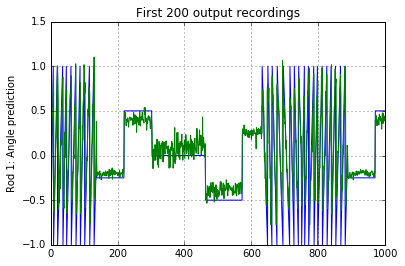

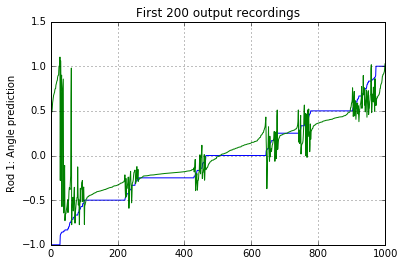

Epoch 70/70
 790/1157 [===================>..........] - ETA: 26s - loss: 0.0498 - mse: 0.1516

In [ ]:

data_path  = ".\\..\\..\\TrainingData\\Processed\\RodTrainingDataAngles\\Result\\settings_full.tsv"
transformer = VideoTransform( zoom_range=0.1, rotation_range=5, width_shift_range=0.1, height_shift_range=0.1, shear_range= 0.1, fill_mode='nearest', vertical_flip=False, horizontal_flip=True, horizontal_flip_invert_indices = [], horizontal_flip_reverse_indices = [], data_format='channels_last' )
training = TrainingInput(transformer, data_path, position_rel_indexes, frame_rel_indexes, 0.05)
lr = 0.00003
print("Updated lr to %f" % lr)
model.compile(optimizer=keras.optimizers.RMSprop(lr=lr),
              loss=[mse_wrap],
              metrics=[mse])

start_epoch = epoch + 1
for epoch in range(start_epoch,200):
    try:
        model.fit_generator(TrainBatchGen(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch)
        model.save_weights(WEIGHTS_FNAME % epoch)
        model.save(MODELS_FNAME % epoch)
        print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
        
        if epoch % 4 == 0:
            plot_validate(ValidateBatchGen(batch_size, model, training), model, 1000, "Angle prediction")   
    except KeyboardInterrupt:
        print("\r\nUser stopped the training.")
        assert(False)
        break

plot_validate(ValidateBatchGen(batch_size, model, training), model, 1000, "Angle prediction")   